# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

# Data

In [114]:
#Directory:
dataDir = '../analysis_data/result_4(25specTest)'
resultDir = dataDir+'/result'

In [115]:
def retrieveData(fileName):
    data = np.load(resultDir+'/'+fileName)
    return data['ch1'], data['ch2'], data['ch3'], data['ch4']

In [116]:
#Input data:
stkData = np.load(dataDir+'/stkData.npz')
wvl_ch1, flux_ch1, err_ch1 = stkData['ch1']
wvl_ch2, flux_ch2, err_ch2 = stkData['ch2']
wvl_ch3, flux_ch3, err_ch3 = stkData['ch3']
wvl_ch4, flux_ch4, err_ch4 = stkData['ch4']

In [117]:
#Consvervative results:
consvResult = np.load(resultDir+'/consvResult.npz')
wvl_bd_ch1, consvGammaBd_ch1, consvCouplingBd_ch1 = consvResult['ch1']
wvl_bd_ch2, consvGammaBd_ch2, consvCouplingBd_ch2 = consvResult['ch2']
wvl_bd_ch3, consvGammaBd_ch3, consvCouplingBd_ch3 = consvResult['ch3']
wvl_bd_ch4, consvGammaBd_ch4, consvCouplingBd_ch4 = consvResult['ch4']
#Conservative chi2 and gamma:
consvChi2_ch1, consvChi2_ch2, consvChi2_ch3, consvChi2_ch4 = retrieveData('consvChi2.npz')
gammaTest1_consv, gammaTest2_consv, gammaTest3_consv, gammaTest4_consv = retrieveData('gammaTest_consv.npz')

In [118]:
#Continuum results:
contResult = np.load(resultDir+'/contResult.npz')
_, contGammaBd_ch1, contCouplingBd_ch1, N1 = contResult['ch1']
_, contGammaBd_ch2, contCouplingBd_ch2, N2 = contResult['ch2']
_, contGammaBd_ch3, contCouplingBd_ch3, N3 = contResult['ch3']
_, contGammaBd_ch4, contCouplingBd_ch4, N4 = contResult['ch4']
#Conservative chi2 and gamma
contChi2_ch1, contChi2_ch2, contChi2_ch3, contChi2_ch4 = retrieveData('contChi2.npz')
gammaTest1_cont, gammaTest2_cont, gammaTest3_cont, gammaTest4_cont = retrieveData('gammaTest_cont.npz')
#Model fits:
modelFit_ch1, modelFit_ch2, modelFit_ch3, modelFit_ch4 = retrieveData('modelFit.npz')

In [119]:
#Sensitivity bands:
gammaBand_ch1, gammaBand_ch2, gammaBand_ch3, gammaBand_ch4 = retrieveData('gammaBand.npz')
#Simulated data:
simData_ch1, simData_ch2, simData_ch3, simData_ch4 = retrieveData('simData.npz')
#Simulated fits:
simFit_ch1, simFit_ch2, simFit_ch3, simFit_ch4 = retrieveData('simFit.npz') 
#Simulated chi2:
simChi2_ch1, simChi2_ch2, simChi2_ch3, simChi2_ch4 = retrieveData('simChi2.npz')

In [120]:
params = np.loadtxt(resultDir+'/params.txt')
testRange = int(params[5])
dof = 2*testRange
step = int(params[7])

In [121]:
#Other constraints:
consDir = '../constraints'
gcData = np.loadtxt(consDir+'/GlobularClusters.txt')
gcM, gcLim = np.transpose(gcData)
nirspcData = np.loadtxt(consDir+'/nirspc.txt')
nirspcM, nirspcLim = np.transpose(nirspcData)

# Functions

In [168]:
def wvlToMass(wvl):
    #um to eV
    return 2*constants.Planck*constants.c/wvl/constants.e/1e-6
    
def gammaToCoupling(gamma,ma):  
    #s-1 => GeV-1
    g = np.sqrt(64*np.pi*658.2119569*gamma/ma**3)
    return g

def model_range(i,wvl,flux,error):
    if (i>=testRange) & (i<=len(wvl)-testRange):
        wvlCut = wvl[i-testRange:i+testRange]
        fluxCut = flux[i-testRange:i+testRange]
        errorCut = error[i-testRange:i+testRange]
    elif (i<testRange):
        wvlCut = wvl[:testRange*2]
        fluxCut = flux[:testRange*2]
        errorCut = error[:testRange*2]
    elif (i>len(wvl)-testRange):
        wvlCut = wvl[-testRange*2:]
        fluxCut = flux[-testRange*2:]
        errorCut = error[-testRange*2:]
    return wvlCut,fluxCut,errorCut
    
def consvChi2AgstGamma(wvl,gammaArr,chi2,xrange=(0,0.5e-23),yrange=(-5,30),interv=100,n=5,fileName=''):
    plt.figure(figsize=(9,6))
    for i in range(n):
        plt.plot(gammaArr,chi2[i*interv,:],'--o',label='$\\lambda_0=$'+str(np.round(wvl[i*interv])))
    plt.legend()
    plt.xlim(xrange)
    plt.ylim(yrange)
    plt.xlabel('$\\Gamma_\\gamma$')
    plt.ylabel('$\\chi^2$')
    if not (fileName==''):
        plt.savefig(fileName)
    plt.show()
    
def showConstraints(wvl,consvGammaBd,consvCouplingBd,contGammaBd,contCouplingBd,gammaBand):
    massArr = wvlToMass(wvl)
    gamma1sigup = gammaBand[:,0]+gammaBand[:,1]
    gamma1siglow = gammaBand[:,0]-gammaBand[:,1]
    gamma2sigup = gammaBand[:,0]+2*gammaBand[:,1]
    gamma2siglow = gammaBand[:,0]-2*gammaBand[:,1]
    couple1sigup = gammaToCoupling(gamma1siglow,massArr)
    couple1siglow = gammaToCoupling(gamma1sigup,massArr)
    couple2sigup = gammaToCoupling(gamma2siglow,massArr)
    couple2siglow = gammaToCoupling(gamma2sigup,massArr)
    
    plt.subplot(211)
    plt.plot(massArr,1/contGammaBd,color='firebrick')
    plt.plot(massArr,1/consvGammaBd,'--',color='black')
    plt.fill_between(massArr,1/gamma1sigup,1/gamma1siglow,color='yellow')
    #plt.fill_between(massArr,1/gamma2sigup,1/gamma2siglow,color='green')
    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(5e-2,1)
    #plt.xticks((0.1,0.5,0.7,1))
    plt.ylim(1e21,1e29)
    plt.yticks((1e23,1e26,1e29))
    plt.xlabel('$m_a$ [eV]')
    plt.ylabel('$\\tau$ [sec]')
    
    plt.subplot(212)
    plt.plot(massArr,contCouplingBd,color='firebrick')
    plt.plot(massArr,consvCouplingBd,'--',color='black')
    plt.fill_between(massArr,couple1sigup,couple1siglow,color='yellow')
    #plt.fill_between(massArr,couple2sigup,couple2siglow,color='green')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(5e-2,1)
    #plt.xticks((1,3,6))
    plt.ylim((1e-12,1e-6))
    plt.yticks([1e-11,1e-9,1e-7])
    plt.xlabel('$m_a$ [eV]')
    plt.ylabel('$g_{\\alpha\\gamma\\gamma}$ [GeV$^{-1}$]')
    plt.tight_layout(pad=0.9)   
    
def fitting_result(wvl, flux, error, wvl_bd, gammaArr, chi2, N, modelFit=np.array([]), simData=np.array([]), simFit=np.array([]), plot_i=np.inf, sim_i=0, N_lim=(0,12), flux_lim=(), gamma_lim=(0,5e-24), chi2_lim=(0,5)):      
    
    #Detection significance:
    plt.figure(figsize=(9,6))
    plt.plot(wvl_bd,N)
    plt.ylim(N_lim)
    plt.axhline(y = 5, color = 'grey', linestyle = '--') 
    plt.xlabel('Wavelength ($\\mu$m)')
    plt.ylabel('N')
    plt.show()
    print('Significant detections:')
    for i in range(len(N)):
        if N[i]>5:
            print('N =', "{:.2f}".format(N[i]), 'at (\u03BB_0,i) =', ("{:.2f}".format(wvl_bd[i]),i))
    max_i = np.argmax(N)
    print('Strongest detection:')
    print('N =', "{:.2f}".format(N[max_i]), 'at (\u03BB_0,i) =', ("{:.2f}".format(wvl_bd[max_i]),max_i))
    
    #Fitting for a specific mass:
    if not (plot_i == np.inf):
        plt.figure(figsize=(9, 6))
        #Spectrum:
        wvl_model, flux_model, error_model = model_range(plot_i*step,wvl,flux,error)  
        plt.subplot(211)
        plt.step(wvl_model,flux_model,'black',label='MRS')
        plt.fill_between(wvl_model,flux_model+error_model,flux_model-error_model,step="pre",color='silver')
        if not (len(modelFit)==0):
            plt.plot(wvl_model,modelFit[plot_i,:,0],color='red',label='Bestfit')
            plt.plot(wvl_model,modelFit[plot_i,:,1],color='blue',label='Bound')
            plt.plot(wvl_model,modelFit[plot_i,:,2],color='cyan',label='Null')
        if not (len(simData)==0):
            plt.scatter(wvl_model,simData[plot_i,sim_i,:],marker='x',s=20,color='green',label='Simulated data')
        if not (len(simFit)==0):
            plt.plot(wvl_model,simFit[plot_i,sim_i,:,0],'--',color='orange',label='sBestfit')
            plt.plot(wvl_model,simFit[plot_i,sim_i,:,1],'--',color='magenta',label='sBound')
            plt.plot(wvl_model,simFit[plot_i,sim_i,:,2],'--',color='navy',label='sNull')
        plt.legend()
        if not(flux_lim==()):
            plt.ylim(flux_lim)
        plt.xlabel('Wavelength ($\\mu$m)')
        plt.ylabel("$\\Phi$ (MJy/sr)")

        #Chi2 against gamma
        plt.subplot(212)
        plt.plot(gammaArr,chi2[plot_i,:]/dof,'-o')
        plt.axhline(y = chi2[plot_i,0]/dof, color = 'grey', linestyle = '--') 
        plt.ylim(chi2_lim)
        plt.xlim(gamma_lim)
        plt.xlabel('$\\Gamma$ (Hz)')
        plt.ylabel('$\\chi^2$/d.o.f.')
        plt.tight_layout(pad=0.9)   
        plt.show() 
        print('chi2/dof =', np.min(chi2[plot_i,:])/dof, 'N =', N[plot_i])

def chi2Dof(wvl1,chi1,wvl2,chi2,wvl3,chi3,wvl4,chi4,figName='chi2Dof.pdf'):
    chi2dof1 = np.min(chi1,axis=1)/dof
    chi2dof2 = np.min(chi2,axis=1)/dof
    chi2dof3 = np.min(chi3,axis=1)/dof
    chi2dof4 = np.min(chi4,axis=1)/dof
    plt.figure(figsize=(9, 6))
    plt.plot(wvl1,chi2dof1)
    plt.plot(wvl2,chi2dof2)
    plt.plot(wvl3,chi2dof3)
    plt.plot(wvl4,chi2dof4)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$\\chi^2/$d.o.f')
    plt.legend(('Ch1','Ch2','Ch3','Ch4'))
    plt.axhline(y = 1, color = 'grey', linestyle = '--')
    if not (figName==''):
        plt.savefig(figName)
    plt.show()

# Plots

## I) Conservative constraints

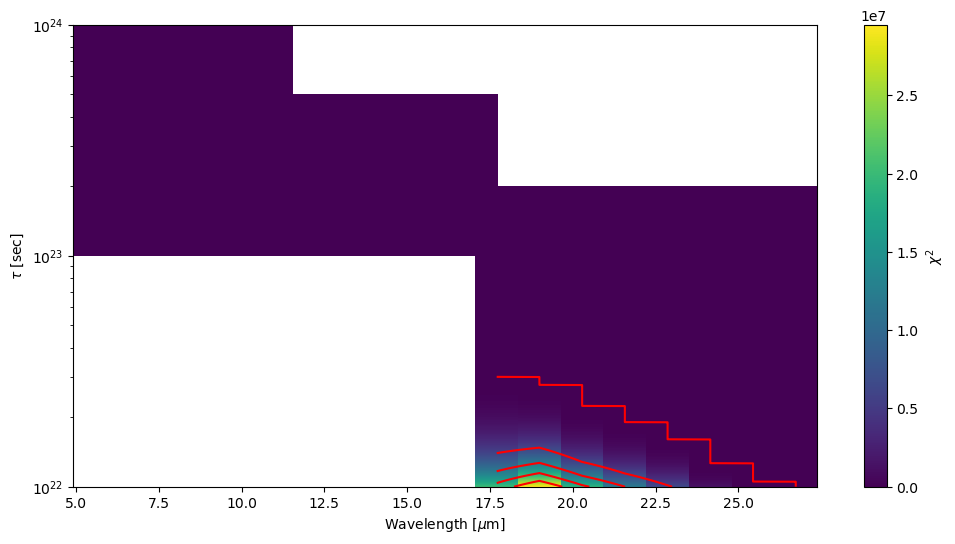

In [171]:
#gammaBd vs wvl
c = 4
wvl1, gammaTest1 = np.meshgrid(wvl_bd_ch1, gammaTest1_consv)
wvl2, gammaTest2 = np.meshgrid(wvl_bd_ch2, gammaTest2_consv)
wvl3, gammaTest3 = np.meshgrid(wvl_bd_ch3, gammaTest3_consv)
wvl4, gammaTest4 = np.meshgrid(wvl_bd_ch4, gammaTest4_consv)
plt.figure(figsize=(12,6))
plt.pcolormesh(wvl1, 1/gammaTest1, np.transpose(consvChi2_ch1))
plt.pcolormesh(wvl2, 1/gammaTest2, np.transpose(consvChi2_ch2))
plt.pcolormesh(wvl3, 1/gammaTest3, np.transpose(consvChi2_ch3))
plt.pcolormesh(wvl4, 1/gammaTest4, np.transpose(consvChi2_ch4))
plt.colorbar(label='$\\chi^2$')
plt.contour(wvl1, 1/gammaTest1, np.transpose(consvChi2_ch1), c, colors='red')
plt.contour(wvl2, 1/gammaTest2, np.transpose(consvChi2_ch2), c, colors='red')
plt.contour(wvl3, 1/gammaTest3, np.transpose(consvChi2_ch3), c, colors='red')
plt.contour(wvl4, 1/gammaTest4, np.transpose(consvChi2_ch4), c, colors='red')
plt.xlabel('Wavelength [$\\mu$m]')
plt.ylabel('$\\tau$ [sec]')
plt.yscale('log')
plt.show()

IndexError: index 20 is out of bounds for axis 0 with size 16

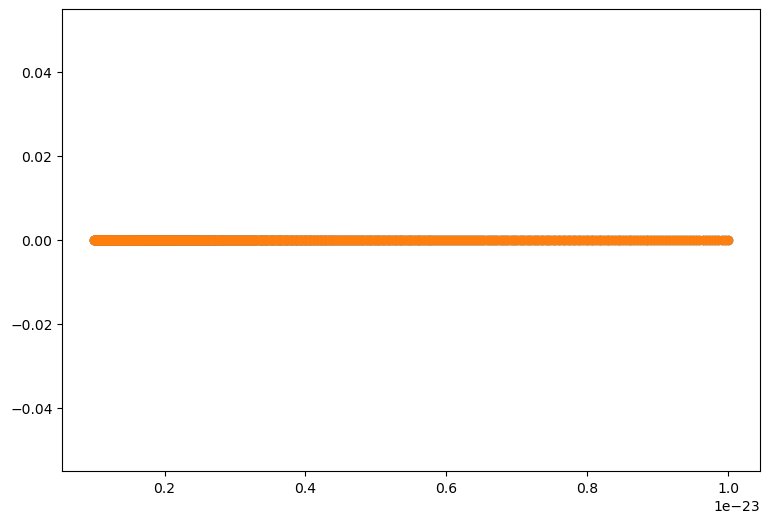

In [174]:
#chi2 vs gamma
consvChi2AgstGamma(wvl_bd_ch1,gammaTest1_consv,consvChi2_ch1,interv=10)

IndexError: index 50 is out of bounds for axis 0 with size 15

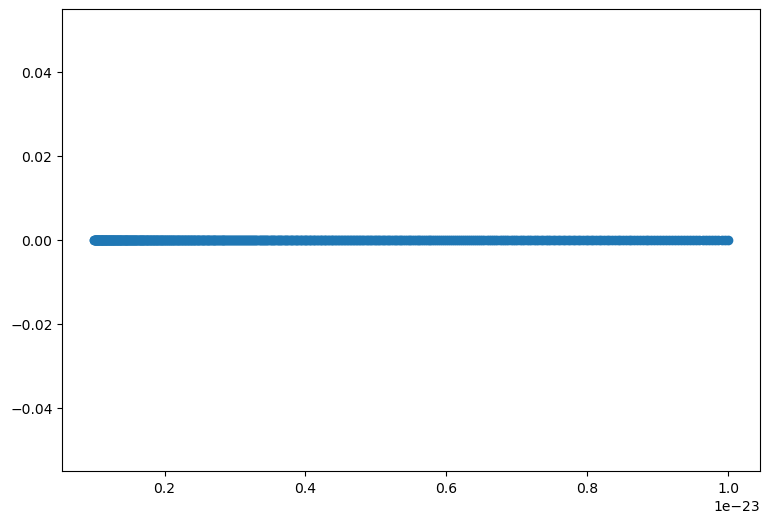

In [175]:
consvChi2AgstGamma(wvl_bd_ch2,gammaTest2_consv,consvChi2_ch2,interv=50,xrange=(0,8e-24))

IndexError: index 20 is out of bounds for axis 0 with size 12

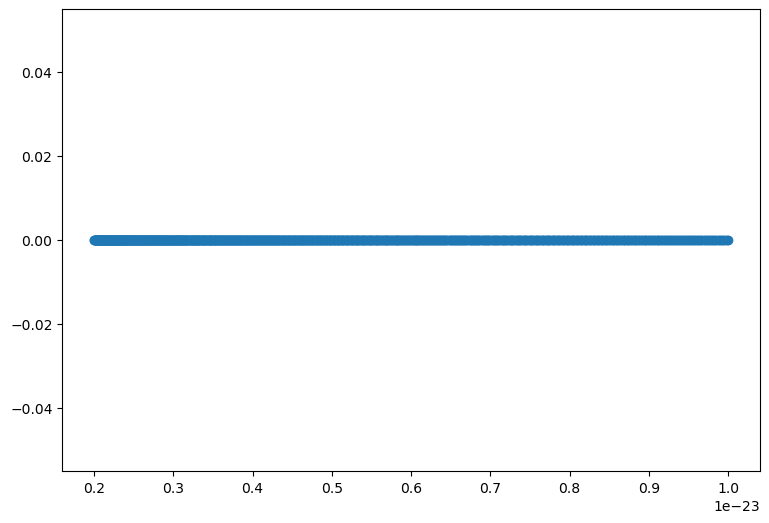

In [176]:
consvChi2AgstGamma(wvl_bd_ch3,gammaTest3_consv,consvChi2_ch3,interv=20,xrange=(0,1e-23))

IndexError: index 10 is out of bounds for axis 0 with size 8

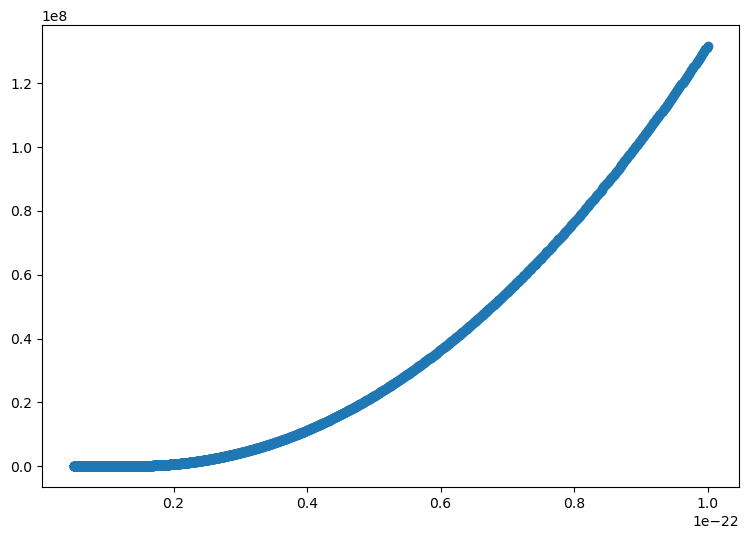

In [193]:
consvChi2AgstGamma(wvl_bd_ch4,gammaTest4_consv,consvChi2_ch4,step=10,xrange=(0,4e-23))

## II) Continuum constraints

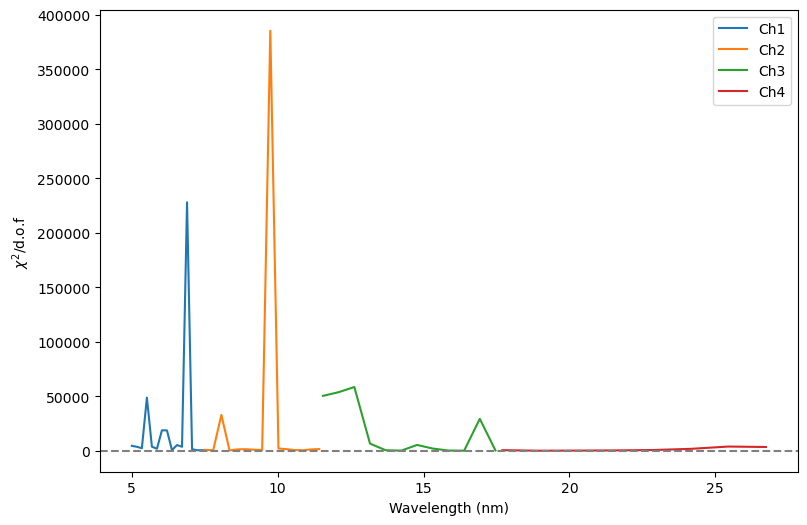

In [123]:
#Goodness of fits:
chi2Dof(wvl_bd_ch1,contChi2_ch1,wvl_bd_ch2,contChi2_ch2,wvl_bd_ch3,contChi2_ch3,wvl_bd_ch4,contChi2_ch4)

/var/folders/f7/gvy2091x4zs844f9q4v7vtxr0000gn/T/ipykernel_87578/4101393293.py:7: RuntimeWarning: invalid value encountered in sqrt
  g = np.sqrt(64*np.pi*658.2119569*gamma/ma**3)


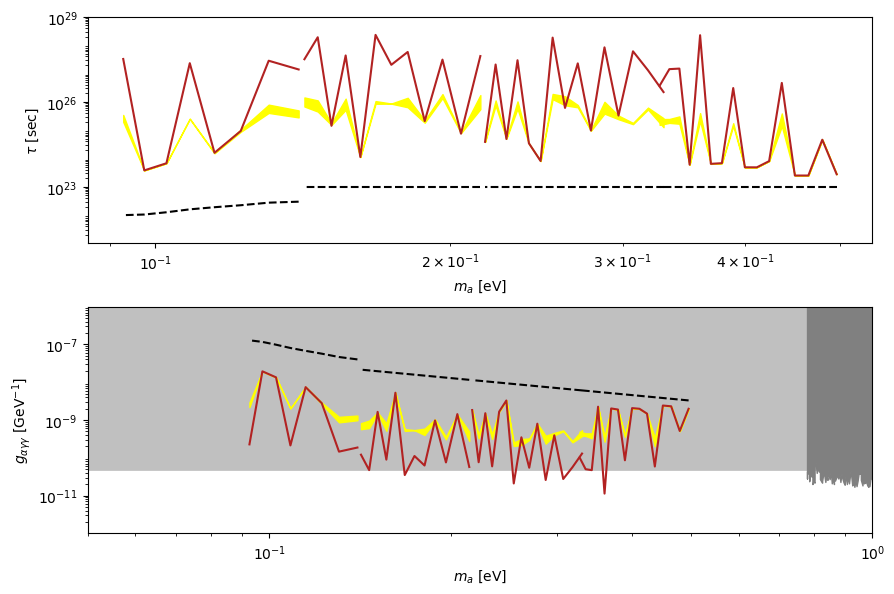

In [124]:
#Constraints:
plt.figure(figsize=(9, 6))
plt.subplot(212)
plt.fill_between(gcM,gcLim,1e-6,color='silver')
plt.fill_between(nirspcM,nirspcLim,1e-6,color='grey')
showConstraints(wvl_bd_ch1,consvGammaBd_ch1,consvCouplingBd_ch1,contGammaBd_ch1,contCouplingBd_ch1,gammaBand_ch1)
showConstraints(wvl_bd_ch2,consvGammaBd_ch2,consvCouplingBd_ch2,contGammaBd_ch2,contCouplingBd_ch2,gammaBand_ch2)
showConstraints(wvl_bd_ch3,consvGammaBd_ch3,consvCouplingBd_ch3,contGammaBd_ch3,contCouplingBd_ch3,gammaBand_ch3)
showConstraints(wvl_bd_ch4,consvGammaBd_ch4,consvCouplingBd_ch4,contGammaBd_ch4,contCouplingBd_ch4,gammaBand_ch4)
plt.savefig('constraints.pdf')
plt.show()

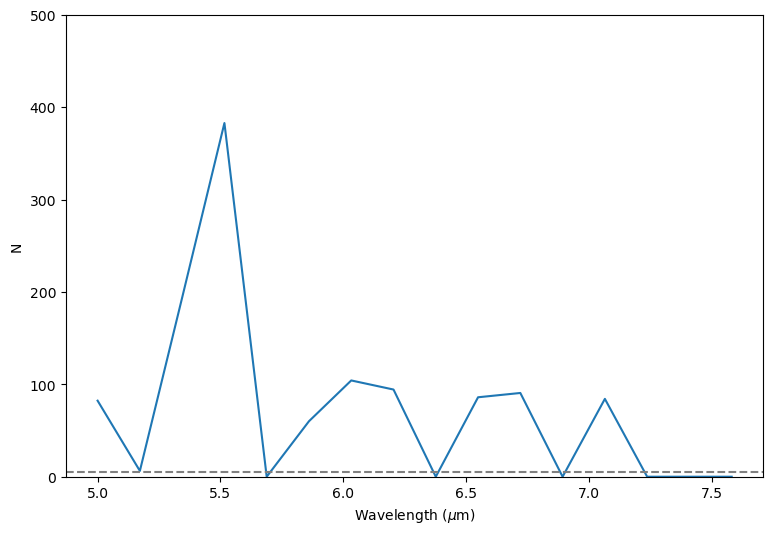

Significant detections:
N = 82.29 at (λ_0,i) = ('5.00', 0)
N = 6.30 at (λ_0,i) = ('5.17', 1)
N = 193.81 at (λ_0,i) = ('5.34', 2)
N = 382.78 at (λ_0,i) = ('5.52', 3)
N = 60.05 at (λ_0,i) = ('5.86', 5)
N = 104.19 at (λ_0,i) = ('6.03', 6)
N = 94.35 at (λ_0,i) = ('6.20', 7)
N = 85.98 at (λ_0,i) = ('6.55', 9)
N = 90.64 at (λ_0,i) = ('6.72', 10)
N = 84.26 at (λ_0,i) = ('7.06', 12)
Strongest detection:
N = 382.78 at (λ_0,i) = ('5.52', 3)


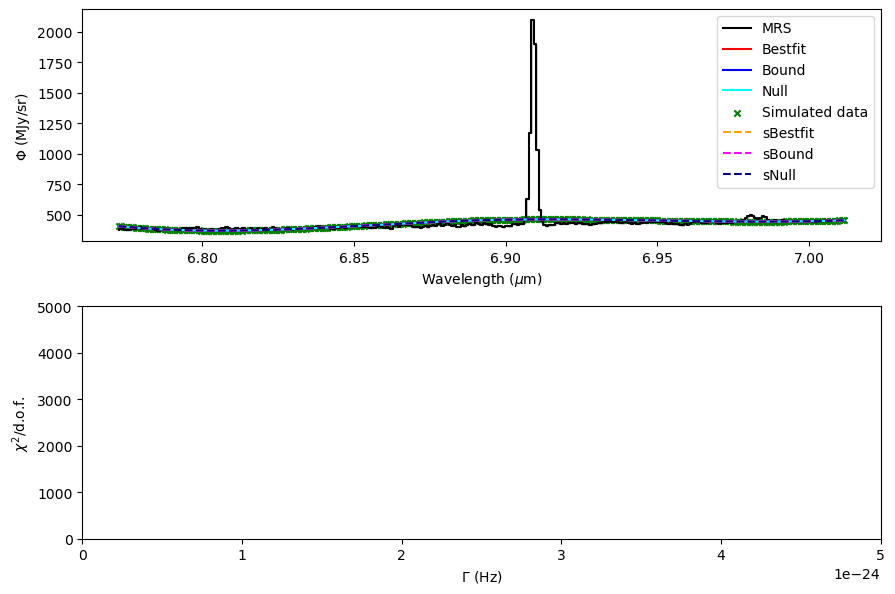

chi2/dof = 228008.0502233714 N = 0.0


In [170]:
fitting_result(wvl_ch1, flux_ch1, err_ch1, wvl_bd_ch1, gammaTest1_cont, contChi2_ch1, N1, 
               plot_i=11, sim_i=0,
               modelFit=modelFit_ch1,
               simFit=simFit_ch1, 
               simData=simData_ch1,
               N_lim = (0,500),
               flux_lim = (),
               chi2_lim = (0,5000)
              )

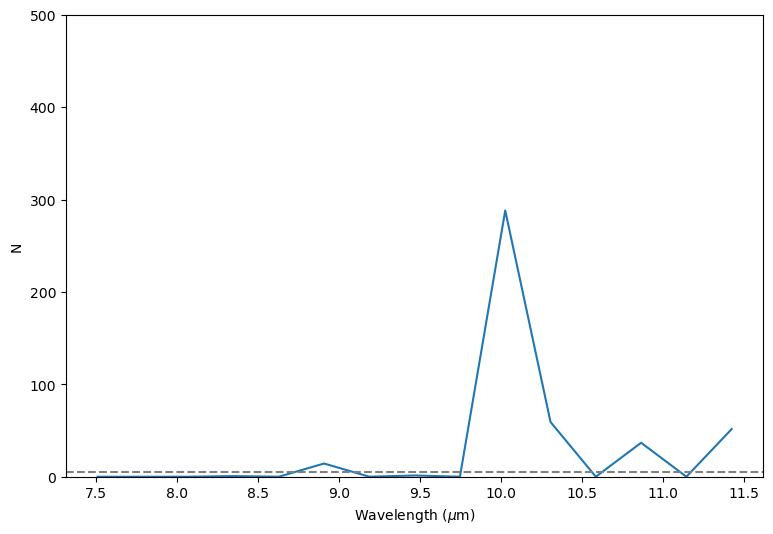

Significant detections:
N = 14.30 at (λ_0,i) = ('8.91', 5)
N = 288.17 at (λ_0,i) = ('10.03', 9)
N = 59.22 at (λ_0,i) = ('10.31', 10)
N = 36.77 at (λ_0,i) = ('10.86', 12)
N = 51.59 at (λ_0,i) = ('11.42', 14)
Strongest detection:
N = 288.17 at (λ_0,i) = ('10.03', 9)


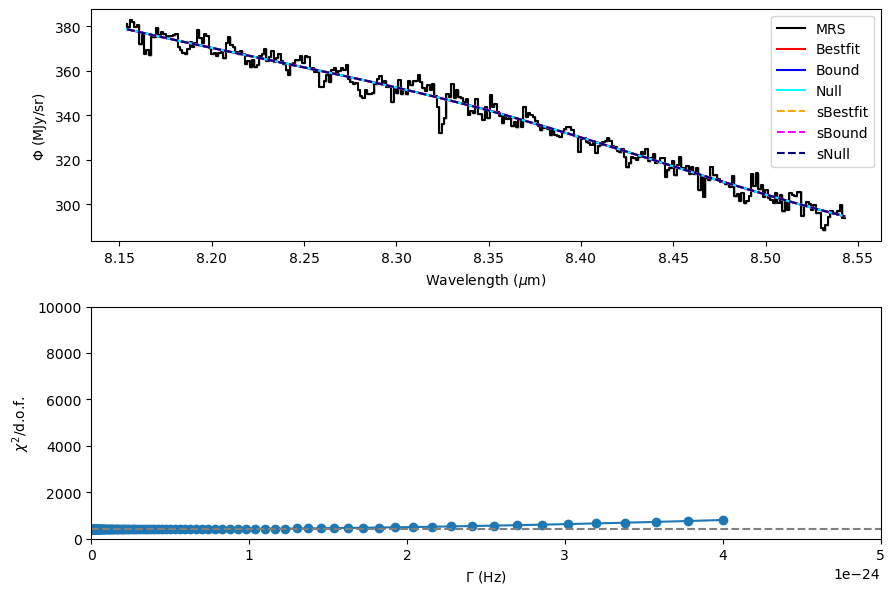

chi2/dof = 397.64640559542204 N = 0.6908263665140408


In [146]:
fitting_result(wvl_ch2, flux_ch2, err_ch2, wvl_bd_ch2, gammaTest2_cont, contChi2_ch2, N2, 
               plot_i=3, sim_i=1,
               modelFit=modelFit_ch2,
               simFit=simFit_ch2, 
               #simData=simData_ch2,
               N_lim = (0,500),
               chi2_lim = (0,10000)
              )

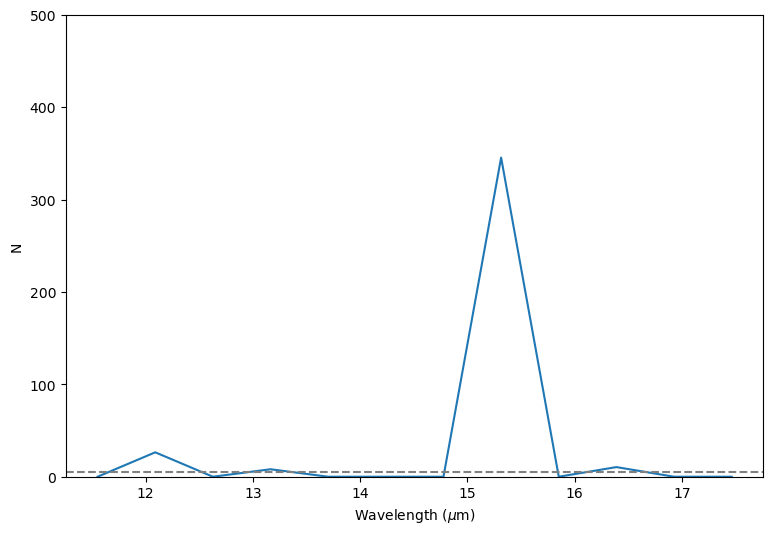

Significant detections:
N = 26.41 at (λ_0,i) = ('12.09', 1)
N = 8.08 at (λ_0,i) = ('13.16', 3)
N = 345.36 at (λ_0,i) = ('15.31', 7)
N = 10.42 at (λ_0,i) = ('16.39', 9)
Strongest detection:
N = 345.36 at (λ_0,i) = ('15.31', 7)


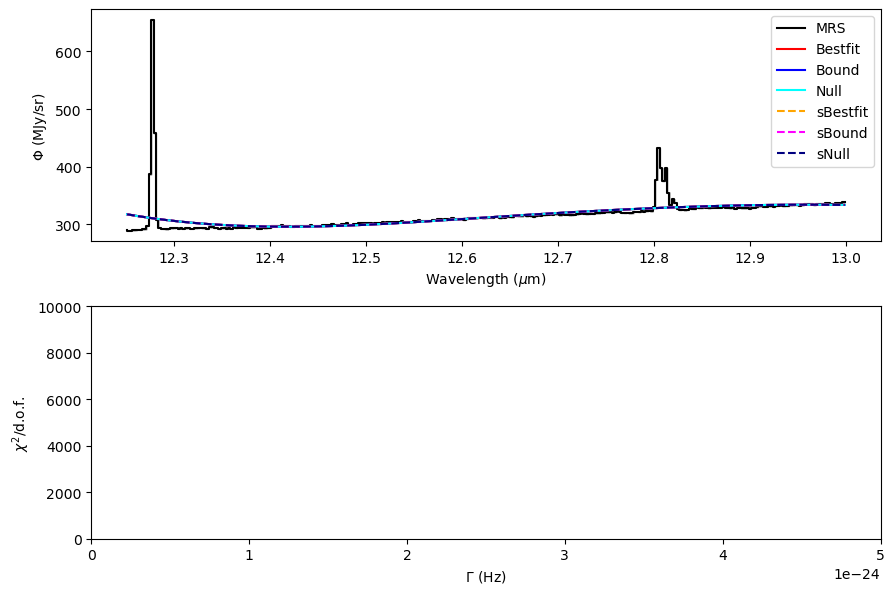

chi2/dof = 58527.77373519246 N = 0.0


In [147]:
fitting_result(wvl_ch3, flux_ch3, err_ch3, wvl_bd_ch3, gammaTest3_cont, contChi2_ch3, N3, 
               plot_i=2, sim_i=0,
               modelFit=modelFit_ch3,
               simFit=simFit_ch3, 
               #simData=simData_ch3,
               N_lim = (0,500),
               chi2_lim = (0,10000)
              )

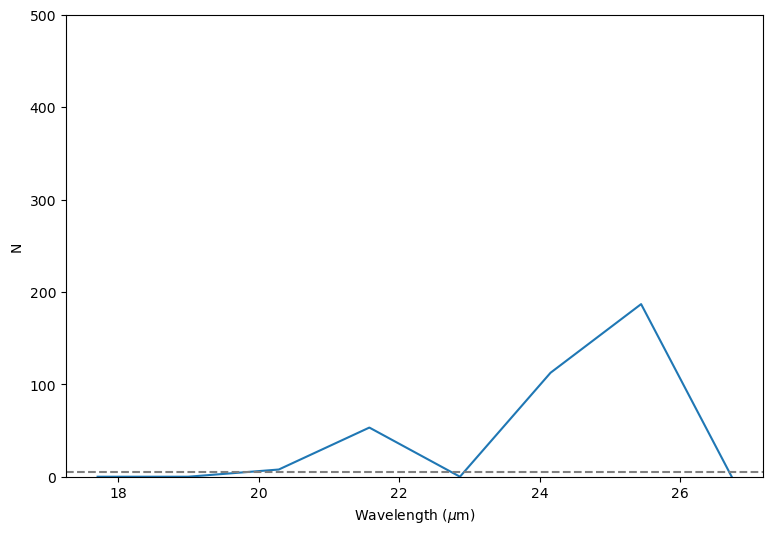

Significant detections:
N = 7.79 at (λ_0,i) = ('20.28', 2)
N = 53.19 at (λ_0,i) = ('21.57', 3)
N = 112.51 at (λ_0,i) = ('24.15', 5)
N = 186.81 at (λ_0,i) = ('25.44', 6)
Strongest detection:
N = 186.81 at (λ_0,i) = ('25.44', 6)


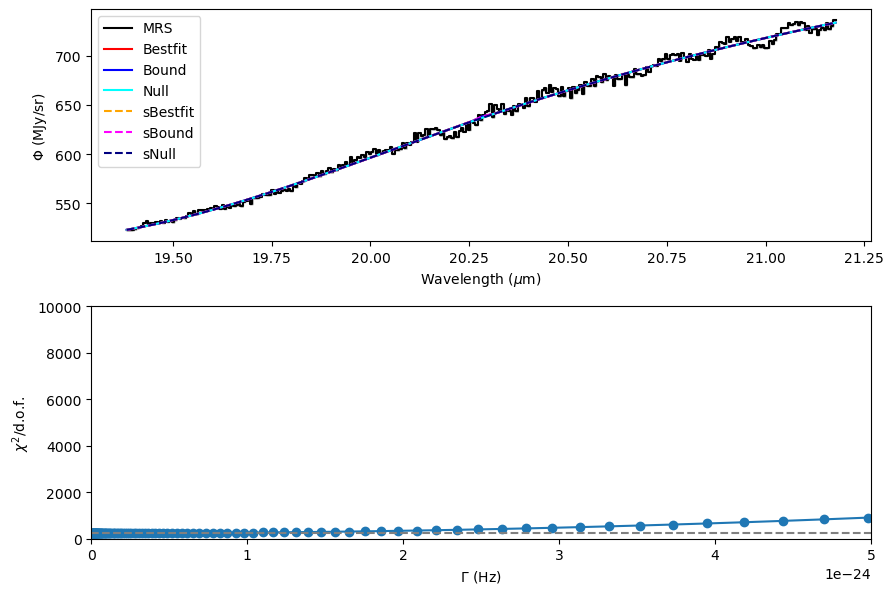

chi2/dof = 240.83423593989767 N = 7.794535058269061


In [148]:
fitting_result(wvl_ch4, flux_ch4, err_ch4, wvl_bd_ch4, gammaTest4_cont, contChi2_ch4, N4, 
               plot_i=2, sim_i=0,
               modelFit=modelFit_ch4,
               simFit=simFit_ch4, 
               #simData=simData_ch4,
               N_lim = (0,500),
               chi2_lim = (0,10000)
              )

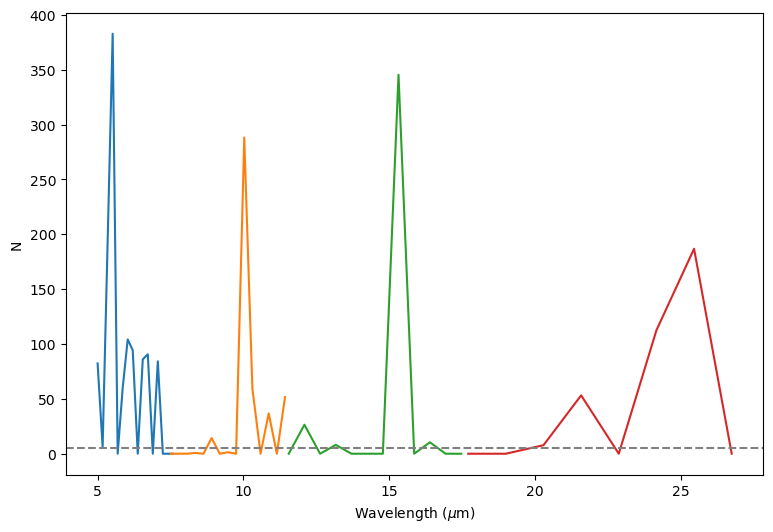

In [129]:
#Detection significance:
plt.figure(figsize=(9,6))
plt.plot(wvl_bd_ch1,N1)
plt.plot(wvl_bd_ch2,N2)
plt.plot(wvl_bd_ch3,N3)
plt.plot(wvl_bd_ch4,N4)
plt.axhline(y = 5, color = 'grey', linestyle = '--') 
plt.xlabel('Wavelength ($\\mu$m)')
plt.ylabel('N')
plt.show()

In [130]:
print(gammaBand_ch1)

[[3.62026667e-24 1.32284771e-26]
 [2.14049068e-25 7.58313688e-28]
 [4.00000000e-24 0.00000000e+00]
 [4.00000000e-24 0.00000000e+00]
 [4.88340238e-26 2.30895676e-26]
 [1.23209508e-24 1.05965203e-26]
 [2.05048047e-24 1.22716342e-27]
 [2.05244589e-24 2.48172583e-27]
 [6.40874049e-26 7.19845346e-27]
 [1.46510616e-24 2.58622409e-27]
 [1.55146491e-24 2.36871600e-27]
 [3.63313185e-26 1.12957566e-26]
 [1.66176014e-24 1.28619052e-26]
 [4.61013609e-26 1.33171122e-26]
 [4.79576577e-26 7.51709020e-27]
 [5.29636473e-26 1.22862450e-26]]


In [131]:
print(contGammaBd_ch1)

[3.60180488e-24 2.17955363e-25 4.00000000e-24 4.00000000e-24
 2.15719069e-27 1.24197565e-24 2.05821402e-24 2.04934136e-24
 3.27360745e-27 1.46735230e-24 1.54632469e-24 4.46228972e-29
 1.65076234e-24 6.72650846e-28 7.03863350e-28 2.71063288e-27]
